In [37]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras as k

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline


In [38]:

df = pd.read_html("https://www.cs.toronto.edu/~kriz/cifar.html")
cifar10_classes = df[0][0].values.tolist()
num_classes = len(cifar10_classes)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0
classes_names = np.array(cifar10_classes)

x_train_df = x_train
y_train = y_train
x_test_df = x_test
y_test = y_test

x_train_df.shape, y_train.shape, x_test_df.shape, y_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [39]:
cifar10_classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [40]:
def define_model():
    weight_decay = 1e-4
    L2 = tf.keras.regularizers.l2(weight_decay)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_regularizer=L2, input_shape=x_train.shape[1:]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_regularizer=L2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'), 
        tf.keras.layers.Dropout(0.2), 

        tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_regularizer=L2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_regularizer=L2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
        tf.keras.layers.Dropout(0.3), 

        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_regularizer=L2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu", kernel_regularizer=L2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
        tf.keras.layers.Dropout(0.4), 

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=128, activation='relu'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=128, activation='relu'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=128, activation='relu'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(units=128, activation='relu'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=10, activation='softmax')
    ])

    opt = tf.keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [41]:
#sample_training_images, _ = next(tf.keras.preprocessing.image.ImageDataGenerator().flow(x_train_df, y_train, batch_size=64))
#images_arr = sample_training_images[:5]
#fig, axes = plt.subplots(1, 5, figsize=(20,20))
#axes = axes.flatten()
#for img, ax in zip( images_arr, axes):
  #ax.imshow(img)
  #ax.axis('off')
  #plt.tight_layout()
  #plt.show()


In [42]:
mean = np.mean(x_train_df, axis=(0,1,2,3))
std = np.std(x_train_df, axis=(0,1,2,3))
x_train = (x_train_df - mean)/(std + 1e-7)
x_test = (x_test_df - mean)/(std + 1e-7)
  

In [43]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=15
)

batch_size = 64

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

In [44]:
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, 
    mode='auto', min_delta=1e-10, cooldown=0, min_lr=0
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=12, verbose=1, mode='auto',
    baseline=None, restore_best_weights=False
)


In [45]:
csv_logger = tf.keras.callbacks.CSVLogger(
    'cifar10.epoch.results.csv', separator='|', append=False)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "cifar10.partial.hdf5", save_weights_only=True, mode='auto', 
    save_freq='epoch', verbose=0
)

In [46]:
model = define_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)      

In [47]:
epochs = 20

history = model.fit(
    train_generator, 
    steps_per_epoch=x_train.shape[0]//batch_size, 
    epochs=epochs,  
    validation_data=(x_test, y_test), 
    callbacks=[csv_logger, reduce_learning_rate, early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/20
781/781 [==============================] - 51s 66ms/step - loss: 2.0993 - accuracy: 0.3125 - val_loss: 1.6760 - val_accuracy: 0.4925
Epoch 2/20
781/781 [==============================] - 50s 65ms/step - loss: 1.3931 - accuracy: 0.5397 - val_loss: 1.1455 - val_accuracy: 0.6278
Epoch 3/20
781/781 [==============================] - 51s 65ms/step - loss: 1.1905 - accuracy: 0.6293 - val_loss: 0.9736 - val_accuracy: 0.7085
Epoch 4/20
781/781 [==============================] - 51s 65ms/step - loss: 1.0897 - accuracy: 0.6802 - val_loss: 0.9417 - val_accuracy: 0.7291
Epoch 5/20
781/781 [==============================] - 51s 65ms/step - loss: 1.0234 - accuracy: 0.7143 - val_loss: 0.8831 - val_accuracy: 0.7608
Epoch 6/20
781/781 [==============================] - 50s 64ms/step - loss: 0.9817 - accuracy: 0.7355 - val_loss: 0.9081 - val_accuracy: 0.7601
Epoch 7/20
781/781 [==============================] - 51s 65ms/step - loss: 0.9443 - accuracy: 0.7540 - val_loss: 0.8595 - val_accuracy:

In [48]:
_, acc = model.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 83.170


In [49]:
model.save('cifar10.h5', overwrite=True, include_optimizer=True, save_format='h5')

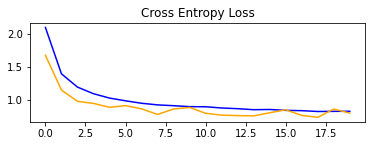

In [50]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')



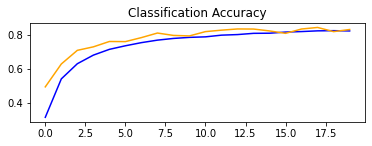

In [51]:
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')

In [52]:
res = pd.read_csv('cifar10.epoch.results.csv', sep='|')
res.tail()

,epoch,accuracy,loss,val_accuracy,val_loss
15,15,0.816505,0.836074,0.8090,0.844260
16,16,0.819529,0.831432,0.8347,0.759763
17,17,0.823734,0.818897,0.8438,0.730261
18,18,0.824816,0.821056,0.8191,0.855858
19,19,0.823214,0.822232,0.8317,0.794152


In [53]:
model_load_tf = tf.keras.models.load_model('cifar10.h5')
model_load_tf.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)      

In [54]:
test_loss, test_acc = model_load_tf.evaluate(x_test, y_test)
print(f"Accuracy: {test_acc} Loss: {test_loss}")

313/313 [==============================] - 3s 9ms/step - loss: 0.7942 - accuracy: 0.8317
Accuracy: 0.8317000269889832 Loss: 0.7941516637802124


In [55]:
Y_test = np.argmax(y_test, axis=1)
y_pred = model.predict_classes(x_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1000
           1       0.83      0.96      0.89      1000
           2       0.80      0.79      0.80      1000
           3       0.91      0.50      0.64      1000
           4       0.81      0.84      0.83      1000
           5       0.76      0.83      0.79      1000
           6       0.69      0.97      0.81      1000
           7       0.94      0.83      0.88      1000
           8       0.94      0.85      0.89      1000
           9       0.86      0.91      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



#VGG16

In [56]:
#  Loading CIFAR10 data

(X_train, y_train), (X_test, y_test) = k.datasets.cifar10.load_data()

print("******************")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
 
# Convert class vectors to binary class matrices using one hot encoding
y_train_ohe = to_categorical(y_train, num_classes = 10)
y_test_ohe = to_categorical(y_test, num_classes = 10)

# Data normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train  /= 255
X_test /= 255

print("******************")
print(X_train.shape)
print(y_train_ohe.shape)
print(X_test.shape)
print(y_test_ohe.shape)



******************
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
******************
(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [57]:
# Using VGG16 model, with weights pre-trained on ImageNet.

vgg16_model = VGG16(weights='imagenet',
                    include_top=False, 
                    classes=10,
                    input_shape=(32,32,3)# input: 32x32 images with 3 channels -> (32, 32, 3) tensors.
                   )

#Define the sequential model and add th VGG's layers to it
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

# Adding hiddens  and output layer to our model

from tensorflow.keras.layers import Dense, Flatten, Dropout
model.add(Flatten())
model.add(Dense(512, activation='relu', name='hidden1'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', name='hidden2'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax', name='predictions'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

In [58]:
# CNN Trained on training data

# initiate SGD optimizer
sgd = optimizers.SGD(lr=0.001, momentum=0.9)

# For a multi-class classification problem
model.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy'])


es = EarlyStopping(patience=5, monitor='val_accuracy', mode='max')
mc = ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=True, mode='max')


In [59]:
# initialize the number of epochs and batch size
EPOCHS = 20
batch_sze = 64

# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                        horizontal_flip=True, fill_mode="nearest")
 

In [60]:
# train the model
history_vgg = model.fit(aug.flow(X_train,y_train_ohe, batch_size=batch_sze),validation_data=(X_test,y_test_ohe), 
                              steps_per_epoch=len(X_train) // batch_sze,epochs=EPOCHS,callbacks=[es,mc])

#We load the best weights saved by the ModelCheckpoint
model.load_weights('./weights.h5')

Epoch 1/20
781/781 [==============================] - 64s 81ms/step - loss: 1.5001 - accuracy: 0.4630 - val_loss: 0.8192 - val_accuracy: 0.7178
Epoch 2/20
781/781 [==============================] - 63s 81ms/step - loss: 0.9795 - accuracy: 0.6668 - val_loss: 0.7435 - val_accuracy: 0.7493
Epoch 3/20
781/781 [==============================] - 63s 81ms/step - loss: 0.8329 - accuracy: 0.7199 - val_loss: 0.6175 - val_accuracy: 0.7942
Epoch 4/20
781/781 [==============================] - 63s 81ms/step - loss: 0.7484 - accuracy: 0.7514 - val_loss: 0.5378 - val_accuracy: 0.8200
Epoch 5/20
781/781 [==============================] - 63s 80ms/step - loss: 0.6798 - accuracy: 0.7751 - val_loss: 0.6210 - val_accuracy: 0.7975
Epoch 6/20
781/781 [==============================] - 63s 81ms/step - loss: 0.6362 - accuracy: 0.7871 - val_loss: 0.5556 - val_accuracy: 0.8169
Epoch 7/20
781/781 [==============================] - 63s 81ms/step - loss: 0.5988 - accuracy: 0.8007 - val_loss: 0.5106 - val_accuracy:

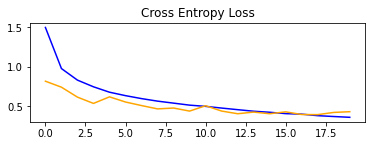

In [62]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history_vgg.history['loss'], color='blue', label='train')
plt.plot(history_vgg.history['val_loss'], color='orange', label='test')


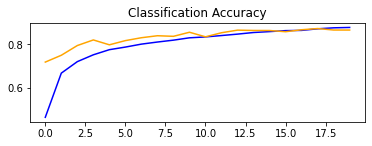

In [64]:

plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history_vgg.history['accuracy'], color='blue', label='train')
plt.plot(history_vgg.history['val_accuracy'], color='orange', label='test')

In [65]:
# PREDICT AND EVALUATE THE CNN ON THE TEST DATA

preds = model.predict(X_test)
score_test = accuracy_score( y_test, np.argmax(preds, axis=1) )
print (' TEST Score : ', score_test)

train_loss, train_score = model.evaluate(X_train, y_train_ohe)
test_loss, test_score = model.evaluate(X_test, y_test_ohe)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)
print("Train Score:", train_score)
print("Test Score:", test_score)

 TEST Score :  0.8726
313/313 [==============================] - 5s 16ms/step - loss: 0.3958 - accuracy: 0.8726
Train Loss: 0.24780631065368652
Test Loss: 0.3958428204059601
Train Score: 0.9158200025558472
Test Score: 0.8726000189781189
